In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
sep = '/'

## To do

    - Select only clusters from cluster group 'good'

In [2]:
path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/2018-05-03_02.dat"
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-05-03_02 (done)'
data = np.memmap(path, shape =(327354368,32), dtype = np.int16)

In [5]:
def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)




Loading Data:	2018-05-03_02 (done)



In [6]:
spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)


Loading Data:	2018-05-03_02 (done)



In [7]:
cluster_to_plot = good_cluster_numbers[12]
num_spikes_for_averaging = 10000
num_channels = 32
num_samples_per_waveform = 60

In [8]:
spike_times_0 = spike_times[spike_clusters==cluster_to_plot]
spike_times_final = spike_times_0.ravel()

In [9]:
df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
df.head()

,cluster,spike_times
0,125,129
1,132,254
2,118,698
3,132,836
4,23,913


In [10]:
df = df.loc[df['cluster'].isin(good_cluster_numbers)]

In [11]:
extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times'][0:num_spikes_for_averaging]

In [12]:
waveform_window = np.arange(int(-num_samples_per_waveform/2),int(num_samples_per_waveform/2))

In [13]:
threeD_matrix = np.zeros((num_spikes_for_averaging, num_samples_per_waveform, num_channels))

In [14]:
for spike in np.arange(0,num_spikes_for_averaging):
    start_index = int(extracted_spikes.iloc[spike]+waveform_window[0])  #  start of waveform in raw data
    end_index = int((extracted_spikes.iloc[spike]+waveform_window[-1])+1)  #  end of waveform in raw data
    
    waveform = data[start_index:end_index, 0:num_channels] #  extract waveform from raw data
    threeD_matrix[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix

mean_waveform = np.mean(threeD_matrix, axis=0)

In [15]:
cols = [''.join(['Chan_', str(num)]) for num in range(1, 33)]

In [16]:
waveform_per_channel_df = pd.DataFrame(mean_waveform, columns=cols)

## Todo
    - Take max of each column
    - Take min of each column
    - Take absolute value of the min and max per column
    - Find column that has the highest distance
    - Plot that column

In [17]:
maxes = waveform_per_channel_df.apply(np.max, axis=0)

In [18]:
lab = maxes.idxmax()

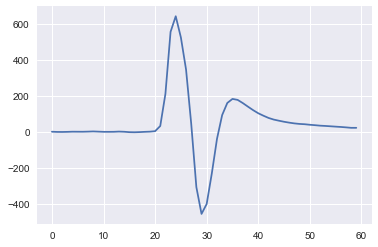

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
correct_chan = waveform_per_channel_df.loc[:, lab]
correct_chan.plot()
plt.show()

In [37]:
correct_chan = correct_chan.reset_index()
correct_chan.columns = ['figure', 'y_values']
correct_chan.set_index('figure', inplace=True)

In [38]:
correct_chan

,y_values
figure,
0,1.0058
1,-0.1259
2,-0.3573
3,0.2362
4,1.1583
5,0.9867
6,0.8861
7,1.6074
8,2.6107


## Calculate half spike width
    - Convert x axis from samples to seconds or ms
    - Find the peak y value, store the x value (time) as a variable
    - Write an algorythm that detect when the y value stops decreases with decreasing x values
    - Return the x value at which this occurs
    - Calculate the distance in time between these points

In [40]:
max_peak_time = correct_chan.idxmax()[0]
min_peak_time = correct_chan.idxmin()[0]
print(min_peak_time)

29


In [42]:
correct_chan.loc[min_peak_time:60].idxmax()[0]

35

In [43]:
reverse_counter = np.arange(max_peak_time, -1 ,-1)

counter = np.arange(max_peak_time, 60, 1)

from_min_to_second_max = np.arange(min_peak_time, correct_chan.loc[min_peak_time:60].idxmax()[0], 1)

from_second_max_to_end = np.arange(correct_chan.loc[min_peak_time:60].idxmax()[0], 60, 1)


In [44]:
from_min_to_second_max

array([29, 30, 31, 32, 33, 34])

In [45]:
baseline = []
return_point = []
second_max = []
last_point = []

time_list_2 = []

for reverse_time_point in reverse_counter:
    if correct_chan.loc[reverse_time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        baseline.append(reverse_time_point)
    else:
        pass

for time_point in counter:
    if correct_chan.loc[time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        time_list_2.append(time_point)
    else:
        pass

for return_time_point in from_min_to_second_max:
    if np.absolute(np.absolute(correct_chan.loc[return_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/2):
        return_point.append(return_time_point)
    else:
        pass

for last_time_point in from_second_max_to_end:
    if np.absolute(np.absolute(correct_chan.loc[last_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/10):
        last_point.append(last_time_point)
    else:
        pass

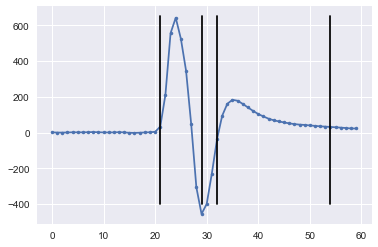

In [47]:
plt.plot(correct_chan, linestyle=None, marker='.')
plt.plot(np.ones(5)*baseline[-1], np.linspace(-400, 650, 5), 'k')
#plt.plot(np.ones(5)*max_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*last_point[-1], np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')

In [53]:
print(correct_chan.loc[32][0])
print(correct_chan.loc[33][0])

gradient = []

-38.3669
93.4291


## Calculate the full spike wide (to troff)
    - Find the minimum value
    - x value
    - calculate the diffference in time between the baseline and the mimum point

In [ ]:
print(min_peak_time)
print(max_peak_time)
print(correct_chan.loc[max_peak_time][0])
print(correct_chan.loc[min_peak_time][0])

Base